<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%98%D1%89%D0%B5%D0%BC_%D1%80%D0%B0%D0%B7%D0%BC%D1%8B%D1%82%D1%8B%D0%B5_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ищем размытые изображения

# Looking for blurry images


В этом уроке мы будем обнаруживать изображения низкого качества, которые будут чрезвычайно сложными для распознавания.

In this lesson we will detect low quality images that will be extremely difficult to recognize.


Это необходимо, так как всегда проще написать код компьютерного зрения для изображений, снятых в идеальных условиях, вместо обработки крайних  и сложных случаев.

This is necessary because it is always easier to write computer vision code for images taken under ideal conditions instead of processing extreme and difficult cases.




Метод, который мы будем использовать, основан на вычислении FFT изображения


> **Fast Fourier transform (FFT)** или же **алгоритм быстрого преобразования Фурье(БПФ)** - это удобный математический алгоритм для вычисления дискретного преобразования Фурье (ДПФ). Он используется для преобразования сигнала из временной области в частотную.








> The **Fast Fourier transform (FFT)** or **fast Fourier transform (FFT)** algorithm is a convenient mathematical algorithm for calculating the discrete Fourier transform (DFT). It is used to convert the signal from the time domain to the frequency domain.

Размытость на изображениях приводит к исчезновению высоких частот, и остаются только низкие частоты. Поэтому мы будем определять размыто изображение или нет по амплитуде высокочастотных составляющих изображения. Для этого мы перенесём изображение в частотную область с помощью fft. Удаляем низкочастотные составляющие, с помощью обратного преобразования восстанавливаем изображение и вычисляем амплитуду. Если амплитуда меньше порогового значения, значит изображение размыто.

Blurring in images leads to disappearance of high frequencies, and only low frequencies remain. Therefore we will determine whether the image is blurred or not by the amplitude of the high-frequency components of the image. To do this, we move the image into the frequency domain with fft. We remove the low-frequency components, use an inverse transform to reconstruct the image, and calculate the amplitude. If the amplitude is less than the threshold value, then the image is blurred.

Напишем сперва дополнительную функцию, которая позволит нам выполнять обнаружение размытия на изображениях


Let's first write an additional function that allows us to perform blur detection on images

In [1]:
# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_16.Detect_blur.zip
!unzip -qq Lesson_16.Detect_blur.zip
%cd Detect_blur

--2022-02-10 11:47:53--  http://dataudt.ru/datasets/cv/Lesson_16.Detect_blur.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5072067 (4.8M) [application/zip]
Saving to: ‘Lesson_16.Detect_blur.zip’

Lesson_16.Detect_bl 100%[===================>]   4.84M  2.12MB/s    in 2.3s    

2022-02-10 11:47:56 (2.12 MB/s) - ‘Lesson_16.Detect_blur.zip’ saved [5072067/5072067]

/content/Detect_blur


In [2]:
# импортируем необходимые пакеты
# import the necessary packages
import numpy as np
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
import cv2

Функция принимает параметры:

The function takes parameters:


- `image` - наше входное изображение для обнаружения размытия. our input image for blur detection.
- `size` ( по умолчанию 60) - размер радиуса вокруг центральной точки изображения, для которого мы обнулим сдвиг FFT. the size of the radius around the center point of the image, for which we will zero the FFT shift.
- `thresh` ( по умолчанию 10) - порог, с которым будет сравниваться среднее значение величин для определения того, считается ли изображение размытым или нет. the threshold against which the average value of the values will be compared to determine whether the image is considered blurred or not.




In [3]:

def detect_blur_fft(image, size=60, thresh=10):
    # получим размеры изображения и используем 
    # их для получения центра координат
    # grab the dimensions of the image and use the dimensions to
	# derive the center (x, y)-coordinates
	(h, w) = image.shape
	(cX, cY) = (int(w / 2.0), int(h / 2.0))

    # вычисляем FFT для нахождения частотного преобразования, 
    # используя встроенную функцию в numpy.
    # Затем мы смещаем нулевую частотную к центру,
    # где ее будет легче анализировать
    # compute the FFT to find the frequency transform, then shift
	# the zero frequency component (i.e., DC component located at
	# the top-left corner) to the center where it will be more
	# easy to analyze
	fft = np.fft.fft2(image)
	fftShift = np.fft.fftshift(fft)

    # обнуляем центр сдвига FFT (т.е. удаляем низкие частоты),
    # применяем обратный сдвиг так, а затем применяем
    # обратное FFT
    # zero-out the center of the FFT shift (i.e., remove low
	# frequencies), apply the inverse shift such that the DC
	# component once again becomes the top-left, and then apply
	# the inverse FFT
	fftShift[cY - size:cY + size, cX - size:cX + size] = 0
	fftShift = np.fft.ifftshift(fftShift)
	recon = np.fft.ifft2(fftShift)

    # вычисляем спектр магнитуд восстановленного изображения,
    # затем вычисляем их среднее значение 
    # compute the magnitude spectrum of the reconstructed image,
	# then compute the mean of the magnitude values
	magnitude = 20 * np.log(np.abs(recon))
	mean = np.mean(magnitude)

    # изображение будет считаться "размытым", если 
    # среднее значение величин меньше порогового значения
    # the image will be considered "blurry" if the mean value of the
	# magnitudes is less than the threshold value
	return (mean, mean <= thresh)



Теперь напишем основную часть, где загрузим входное изображение, а затем применим функцию обнаружения размытия




Now let's write the main part, where we load the input image and then apply the blur detection function

In [4]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  "image" : "/content/Detect_blur/images/example_03.png", # путь входного изображения, на котором мы будем определять размытость
                                                        # the path of the input image where we will determine the blurring
  "thresh": 15, # порог срабатывания детектора размытости
                # blur detector threshold
}


[INFO] Blurry (8.1789)


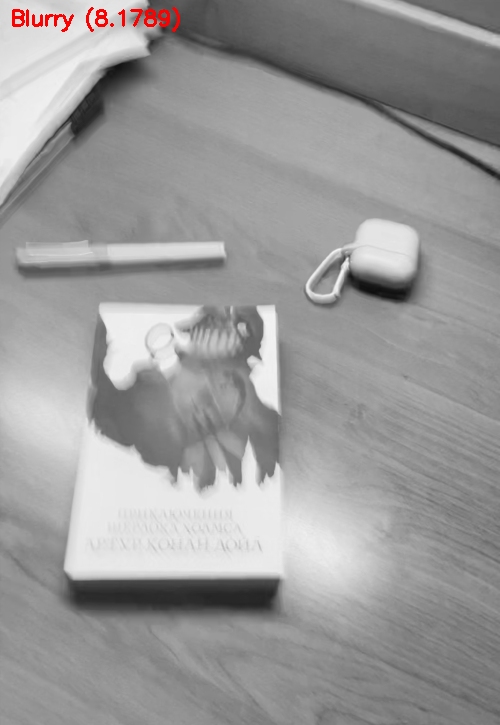

In [5]:
# загружаем входное изображение с диска, изменяем 
# его размер и преобразуем в оттенки серого
# load the input image from disk, resize it, and convert it to
# grayscale
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=500)
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# применяем наш детектор размытия, используя FFT
# apply our blur detector using the FFT
(mean, blurry) = detect_blur_fft(gray, size=60,
	thresh=args["thresh"])

# рисуем на изображении, указывая, размыто оно или нет
# draw on the image, indicating whether or not it is blurry
image = np.dstack([gray] * 3)
color = (0, 0, 255) if blurry else (0, 255, 0)
text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
text = text.format(mean)
cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, color, 2)
print("[INFO] {}".format(text))

# показываем выходное изображение
# show the output image
cv2_imshow(image)

Видим, что изображение определяется, как размытое, что таковым и является.

Теперь посмотрим на качественное изображение:


We see that the image is defined as blurred, which it is.

Now let's look at the quality image:

In [6]:
args2 = {
  "image" : "/content/Detect_blur/images/example_02.png", # путь входного изображения, на котором мы будем определять размытость
                                                            # the path of the input image where we will determine the blurring
  "thresh": 15, # порог срабатывания детектора размытости
                 # blur detector threshold
}

[INFO] Not Blurry (26.8913)


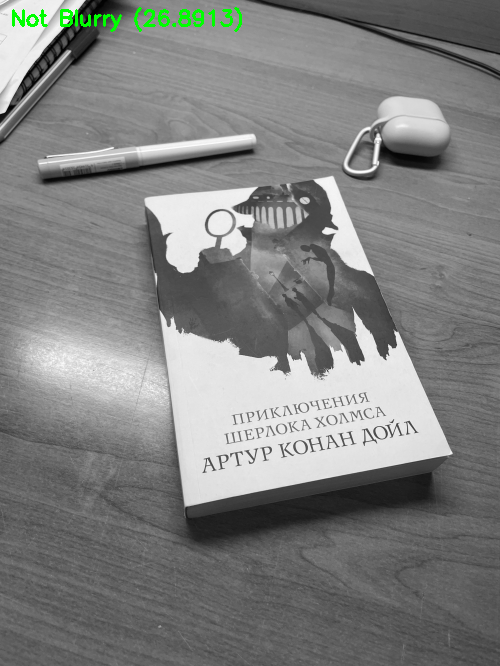

In [7]:
# загружаем входное изображение с диска, изменяем 
# его размер и преобразуем в оттенки серого
# load the input image from disk, resize it, and convert it to
# grayscale
orig = cv2.imread(args2["image"])
orig = imutils.resize(orig, width=500)
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# применяем наш детектор размытия, используя FFT
# apply our blur detector using the FFT
(mean, blurry) = detect_blur_fft(gray, size=60,
	thresh=args2["thresh"])

# рисуем на изображении, указывая, размыто оно или нет
# draw on the image, indicating whether or not it is blurry
image = np.dstack([gray] * 3)
color = (0, 0, 255) if blurry else (0, 255, 0)
text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
text = text.format(mean)
cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, color, 2)
print("[INFO] {}".format(text))

# показываем выходное изображение
# show the output image
cv2_imshow(image)

Все верно. Данное изображение распознается, как не размытое, и с ним можно дальше работать.


This is correct. This image is recognized as not blurred, and you can continue to work with it.